In [3]:
pip install tensorflow

  Using cached tensorflow-2.16.1-cp311-cp311-macosx_10_15_x86_64.whl.metadata (4.1 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.5.4-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached h5py-3.11.0-cp311-cp311-macosx_10_9_x86_64.whl.metadata (2.5 kB)
  Using cached libclang-18.1.1-py2.py3-none-macosx_10_9_x86_64.whl.metadata (5.2 kB)
  Using cached ml_dtypes-0.3.2-cp311-cp311-macosx_10_9_universal2.whl.metadata (20 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached grpcio-1.62.2-cp311-cp311-macosx_10_10_universal2.whl.metadata (4.0 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached keras-3.3.2-

### Import Libraries
##### Import necessary Python libraries required for data handling, machine learning model building, and computation.


In [43]:
import json
import pandas as pd
import numpy as np
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense
from sklearn.model_selection import train_test_split

### Define Helper Functions
##### Define functions for loading data from JSON files and cleaning text data. These functions help modularize the code for better readability and reuse.


In [44]:
# Function to load data from a JSON file
def load_data(file_name):
    with open(file_name, 'r') as file:
        data = json.load(file)
    return pd.DataFrame.from_dict(data, orient='index')

# Function to clean text data
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower().strip()
    return text

### Load and Prepare Data
##### Load the data from JSON files into Pandas DataFrames. This includes cleaning the text data and preparing it for further processing.


In [50]:
# Load data
HR_df = load_data('data/HR.json')
HF_df = load_data('data/HF.json')
MR_df = load_data('data/MR.json')
MF_df = load_data('data/MF.json')

tokenizer = Tokenizer(num_words=5000)
all_texts = pd.concat([HR_df['text'], HF_df['text'], MR_df['text'], MF_df['text']])
all_texts = all_texts.apply(clean_text)
tokenizer.fit_on_texts(all_texts)

### Building the CNN Model for Text Classification
- **CNN Model**: While traditionally used for image processing, CNNs are effective in text classification because they can pick up patterns (like word groupings and order) in text data through their convolutional layers.
- **Methods**:
  - The `create_cnn_model` function builds a CNN that processes text data transformed into numerical format through an embedding layer.
  - The convolutional layers (`Conv1D`) extract features from the text, focusing on local relationships within the data. This is particularly useful for capturing the stylistic nuances that may differentiate AI-generated text from human-written text.
  - Pooling layers (`MaxPooling1D` and `GlobalMaxPooling1D`) reduce the dimensionality of the data, concentrating on the most significant features from the convolutional layers.
  - The final dense layers classify the input into one of two categories: human or AI-generated, based on the features extracted and summarized by the previous layers.
- **Rationale/Assumptions**:
  - We assume that AI-generated texts exhibit certain predictable patterns or anomalies that are distinguishable from human-written texts. These could be unusual word combinations or syntactic structures.
  - By training this CNN on labeled datasets of human and AI-generated articles, the model learns to identify and leverage these distinguishing features.
- **Limitations/Caveats**:
  - CNNs may not capture long-term dependencies in text as effectively as sequence models like LSTMs or transformers. This could be a limitation when dealing with longer articles where context spread across the text is crucial.
  - The effectiveness of the CNN relies heavily on the quality and variety of the training data. Biases in the training dataset could lead to inaccurate classifications.

#### Viewing the Model Architecture
  - Viewing the model architecture allows us to verify that the model is structured correctly for our specific text classification task. It ensures that the layers are properly configured and connected, and that the model's complexity is suitable for handling the nuances between human-written and AI-generated texts.
  - It also provides a quick overview of the trainable and non-trainable parameters, helping gauge the computational demand and efficiency of the model.

In [88]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense

def create_cnn_model():
    model = Sequential([
        Embedding(5000, 50, input_length=100),
        Conv1D(128, 5, activation='relu'),
        MaxPooling1D(5),
        Conv1D(128, 5, activation='relu'),
        GlobalMaxPooling1D(),
        Dense(10, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Explicitly build the model
    model.build(input_shape=(None, 100))  # Specify the input shape explicitly with batch size flexibility
    return model

# Create the model
model = create_cnn_model()

# Now call the summary method to see the model architecture
try:
    print(model.summary())
except ValueError as e:
    print(e)


Model: "sequential_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_162 (Embedding)       │ (None, 100, 50)        │       250,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_324 (Conv1D)             │ (None, 96, 128)        │        32,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_162               │ (None, 19, 128)        │             0 │
│ (MaxPooling1D)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_325 (Conv1D)             │ (None, 15, 128)        │        82,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_162        │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_324 (Dense)               │ (None, 10)             │         1,290 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_325 (Dense)               │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 365,477 (1.39 MB)

 Trainable params: 365,477 (1.39 MB)

 Non-trainable params: 0 (0.00 B)

None


### Data Preparation for Text Comparison
  1. **Text Concatenation and Cleaning**: Merge texts from two datasets and clean them to ensure uniformity, removing noise and standardizing formatting.
  2. **Tokenization**: Convert cleaned texts into sequences of integers with a pre-defined tokenizer, where each integer represents a specific word.
  3. **Padding**: Standardize sequence lengths by padding shorter sequences with zeros to ensure consistent input size for the CNN.
  4. **Labeling**: Assign binary labels to the sequences, indicating whether the text is human-written (`0`) or AI-generated (`1`).
- **Rationale**:
  - Uniform sequence lengths and cleaned texts allow the CNN to process data efficiently, crucial for accurate classification.
  - Binary labels facilitate supervised learning, training the model to predict the correct class for new articles.

In [89]:
def prepare_data_for_comparison(df1, df2):
    combined_texts = pd.concat([df1['text'], df2['text']]).apply(clean_text)
    sequences = tokenizer.texts_to_sequences(combined_texts)
    X = pad_sequences(sequences, maxlen=100)
    labels = np.array([0] * len(df1) + [1] * len(df2))
    return X, labels

### Model Training and Evaluation
  1. **Splitting Data**: Divide the data into training and testing sets to ensure the model is tested on unseen data.
  2. **Model Initialization**: Instantiate a new CNN model configured for binary classification.
  3. **Model Training**: Train the model using the training data for a defined number of cycles (epochs), with validation during training to monitor and prevent overfitting.
  4. **Model Evaluation**: Assess the model's performance using the test set to obtain accuracy metrics.
- **Rationale**:
  - **Epochs** refer to the number of complete passes through the entire training dataset. More epochs can lead to better learning but might also cause overfitting if not monitored with validation data.
  - **Overfitting** occurs when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. It means the model is too complex, capturing patterns in the training data that do not generalize to unseen data.
  - Training with validation helps in tuning the model parameters appropriately and provides insights into how well the model generalizes to new data.
  - Using a test set separate from the training data provides an unbiased evaluation of the model's final performance.
- **Outputs**:
  - The function returns the model's accuracy on the test set and the training history for further analysis.

In [95]:
def train_and_evaluate(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = create_cnn_model()
    history = model.fit(X_train, y_train, epochs=10, validation_split=0.1)  # Save the history of the fit
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    return test_accuracy, history


#### Comparison of Model Performance Across Different Data Pairs
- **Purpose**: Evaluate the CNN model across all possible pairs of data categories to determine how well the model differentiates between various types of texts (Human Real, Human Fake, AI Real, AI Fake).

  1. **Data Pairing**: Compare each pair of data categories to understand specific performance metrics like accuracy for each scenario.
  2. **Model Training and Evaluation**: For each pair, train and evaluate the model using the previously defined `train_and_evaluate` function.
  3. **History Storage**: Store the training history for each comparison to analyze trends such as accuracy improvements or signs of overfitting across epochs.
- **Rationale**:
  - Comparing all possible pairs helps identify which types of texts are more challenging for the model to differentiate. This can guide further tuning of the model or prompt the use of different modeling techniques if certain pairs show significantly lower performance.

In [96]:
comparison_results = {}
histories = {}  # Dictionary to store history objects

# Perform comparisons and store histories
comparison_results['Human Real vs Human Fake'], histories['Human Real vs Human Fake'] = train_and_evaluate(*prepare_data_for_comparison(HR_df, HF_df))
comparison_results['Human Real vs AI Real'], histories['Human Real vs AI Real'] = train_and_evaluate(*prepare_data_for_comparison(HR_df, MR_df))
comparison_results['Human Fake vs AI Real'], histories['Human Fake vs AI Real'] = train_and_evaluate(*prepare_data_for_comparison(HF_df, MR_df))
comparison_results['Human Fake vs AI Fake'], histories['Human Fake vs AI Fake'] = train_and_evaluate(*prepare_data_for_comparison(HF_df, MF_df))
comparison_results['AI Real vs AI Fake'], histories['AI Real vs AI Fake'] = train_and_evaluate(*prepare_data_for_comparison(MR_df, MF_df))
comparison_results['Human Real vs AI Fake'], histories['Human Real vs AI Fake'] = train_and_evaluate(*prepare_data_for_comparison(HR_df, MF_df))


Epoch 1/10


/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5047 - loss: 0.6938 - val_accuracy: 0.4886 - val_loss: 0.6932
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5069 - loss: 0.6931 - val_accuracy: 0.4886 - val_loss: 0.6932
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5155 - loss: 0.6930 - val_accuracy: 0.4886 - val_loss: 0.6932
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5113 - loss: 0.6931 - val_accuracy: 0.4886 - val_loss: 0.6933
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.5035 - loss: 0.6931 - val_accuracy: 0.4886 - val_loss: 0.6933
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5085 - loss: 0.6931 - val_accuracy: 0.4886 - val_loss: 0.6934
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.4973 - loss: 0.6932 - val_accuracy: 0.4886 - val_loss: 0.6934
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.4961 - loss: 0.6932 - val_accuracy: 0.488

/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.6355 - loss: 0.6124 - val_accuracy: 0.8393 - val_loss: 0.3668
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8931 - loss: 0.2845 - val_accuracy: 0.8093 - val_loss: 0.3884
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9284 - loss: 0.2036 - val_accuracy: 0.8258 - val_loss: 0.4187
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9437 - loss: 0.1656 - val_accuracy: 0.8018 - val_loss: 0.5270
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9580 - loss: 0.1321 - val_accuracy: 0.8018 - val_loss: 0.5560
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.9564 - loss: 0.1230 - val_accuracy: 0.7958 - val_loss: 0.5725
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9647 - loss: 0.0951 - val_accuracy: 0.8018 - val_loss: 0.5490
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9724 - loss: 0.0772 - val_accuracy: 0.797

/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


186/186 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - accuracy: 0.5967 - loss: 0.6368 - val_accuracy: 0.8835 - val_loss: 0.2644
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9238 - loss: 0.2062 - val_accuracy: 0.8956 - val_loss: 0.2498
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.9712 - loss: 0.0944 - val_accuracy: 0.8865 - val_loss: 0.3077
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9910 - loss: 0.0422 - val_accuracy: 0.8880 - val_loss: 0.3811
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9965 - loss: 0.0150 - val_accuracy: 0.8820 - val_loss: 0.4547
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9976 - loss: 0.0108 - val_accuracy: 0.8805 - val_loss: 0.4999
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9988 - loss: 0.0048 - val_accuracy: 0.8820 - val_loss: 0.5143
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9983 - loss: 0.0057 - val_accuracy: 0.875

/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


184/184 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.7003 - loss: 0.5283 - val_accuracy: 0.9404 - val_loss: 0.1573
Epoch 2/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9740 - loss: 0.0756 - val_accuracy: 0.9419 - val_loss: 0.1736
Epoch 3/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9950 - loss: 0.0220 - val_accuracy: 0.9373 - val_loss: 0.1933
Epoch 4/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9993 - loss: 0.0072 - val_accuracy: 0.9465 - val_loss: 0.2081
Epoch 5/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9997 - loss: 0.0042 - val_accuracy: 0.9465 - val_loss: 0.2301
Epoch 6/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9993 - loss: 0.0052 - val_accuracy: 0.9480 - val_loss: 0.2392
Epoch 7/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9997 - loss: 0.0017 - val_accuracy: 0.9495 - val_loss: 0.2481
Epoch 8/10
184/184 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9997 - loss: 0.0024 - val_accuracy: 0.945

/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6236 - loss: 0.6173 - val_accuracy: 0.8941 - val_loss: 0.2619
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9452 - loss: 0.1473 - val_accuracy: 0.9032 - val_loss: 0.2325
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9837 - loss: 0.0564 - val_accuracy: 0.9032 - val_loss: 0.3181
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9960 - loss: 0.0172 - val_accuracy: 0.9062 - val_loss: 0.4081
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9993 - loss: 0.0041 - val_accuracy: 0.9107 - val_loss: 0.4704
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 1.0000 - loss: 8.7892e-04 - val_accuracy: 0.9138 - val_loss: 0.5048
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9995 - loss: 0.0013 - val_accuracy: 0.9123 - val_loss: 0.5384
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 1.0000 - loss: 1.8672e-04 - val_accurac

/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


186/186 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.6994 - loss: 0.5314 - val_accuracy: 0.9423 - val_loss: 0.1416
Epoch 2/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9698 - loss: 0.0852 - val_accuracy: 0.9530 - val_loss: 0.1431
Epoch 3/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9931 - loss: 0.0299 - val_accuracy: 0.9545 - val_loss: 0.1801
Epoch 4/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9977 - loss: 0.0115 - val_accuracy: 0.9514 - val_loss: 0.1961
Epoch 5/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9998 - loss: 0.0026 - val_accuracy: 0.9484 - val_loss: 0.2393
Epoch 6/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.9530 - val_loss: 0.2163
Epoch 7/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9998 - loss: 0.0019 - val_accuracy: 0.9575 - val_loss: 0.2328
Epoch 8/10
186/186 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9995 - loss: 0.0039 - val_accuracy: 0.954

### Sort and Display Comparison Results
##### Sort the comparison results by accuracy in descending order and display them to identify the most to least accurate models.


In [97]:
# Sort the DataFrame by the 'Accuracy' column in descending order
results_df = results_df.sort_values(by='Accuracy', ascending=False)
print(results_df)

  Comparison  Accuracy
5   HR vs MF  0.903970
3   HF vs MF  0.888472
2   HF vs MR  0.800679
1   HR vs MR  0.673276
4   MR vs MF  0.505150
0   HR vs HF  0.504189


#### Visualization of Model Training and Validation Metrics
  1. **Setup**: Generate two subplots—one for accuracy and the other for loss.
  2. **Accuracy Plot**: Show both training and validation accuracy over epochs. Training accuracy indicates how well the model is learning the dataset, while validation accuracy shows how well the model generalizes to new data.
  3. **Loss Plot**: Display training and validation loss over epochs. Training loss measures how well the model fits the data, whereas validation loss measures model performance on the unseen data.
- **Rationale**:
  - **Accuracy and Loss Trends**:
    - **Consistent Increase in Validation Accuracy** and **Decrease in Validation Loss** suggest good model generalization.
    - **Large Gaps between Training and Validation Metrics** may indicate **overfitting**, where the model learns the training data too well, including the noise and errors, at the expense of its ability to generalize.
    - **High Validation Loss** or **Plateaus in Validation Accuracy** can signal **underfitting**, where the model does not perform well even on training data, suggesting it is too simple.
- **Outputs**:
  - A combined plot with training and validation accuracy and loss, providing a visual representation of the model's learning curve and its ability to generalize across epochs.

In [98]:
import matplotlib.pyplot as plt

def plot_history(history, comparison_name):
    plt.figure(figsize=(12, 6))
    plt.suptitle(f'Model Training and Validation Metrics for {comparison_name}')
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


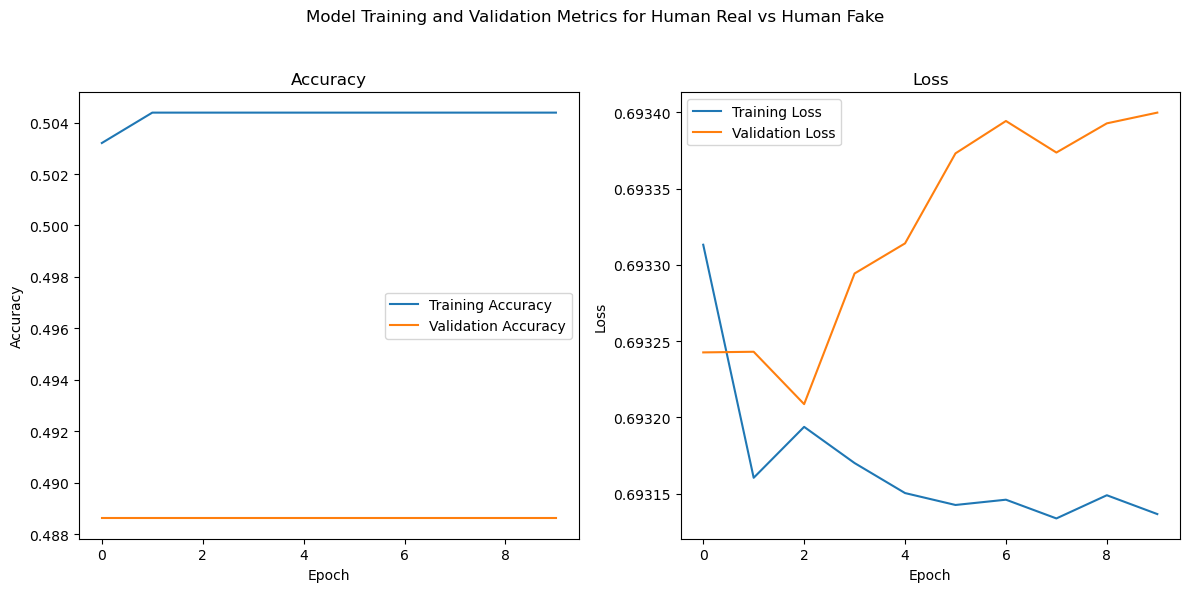

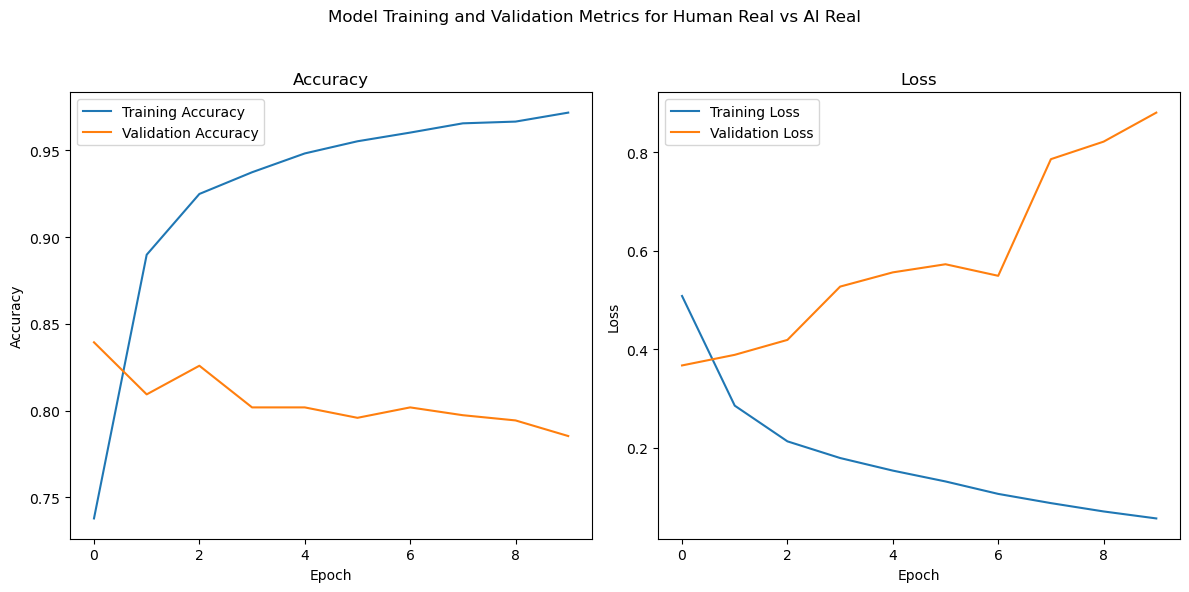

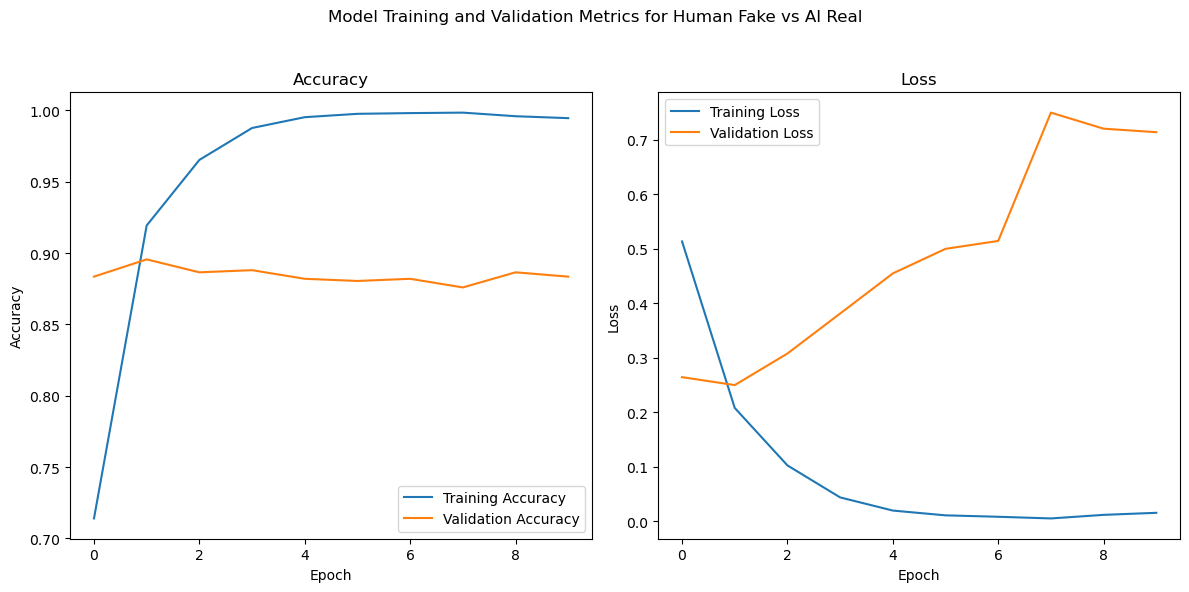

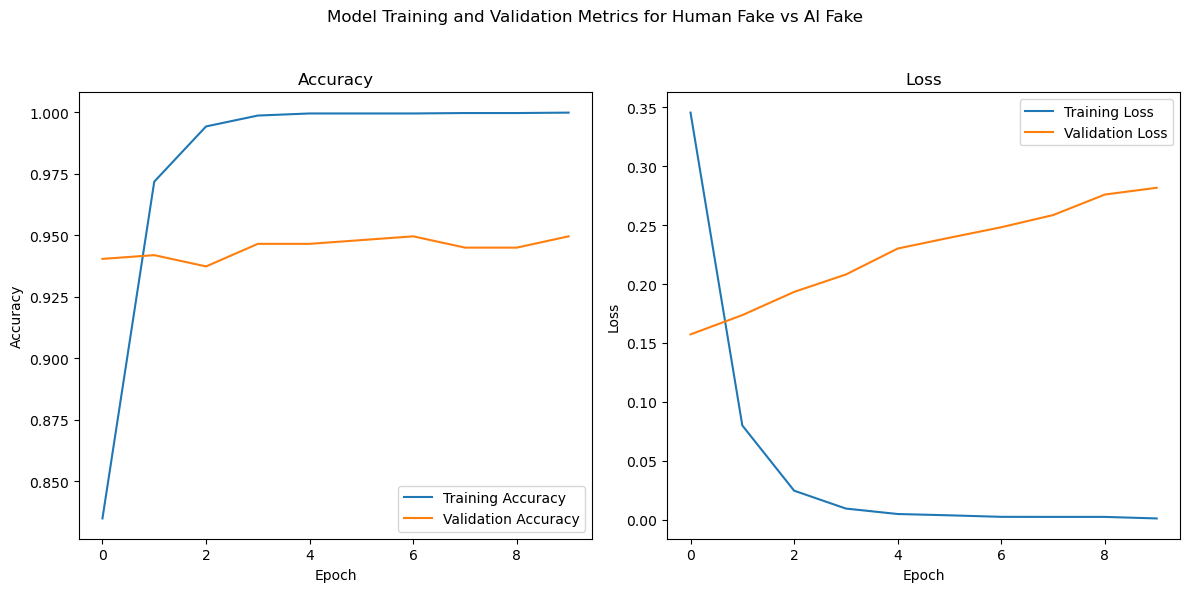

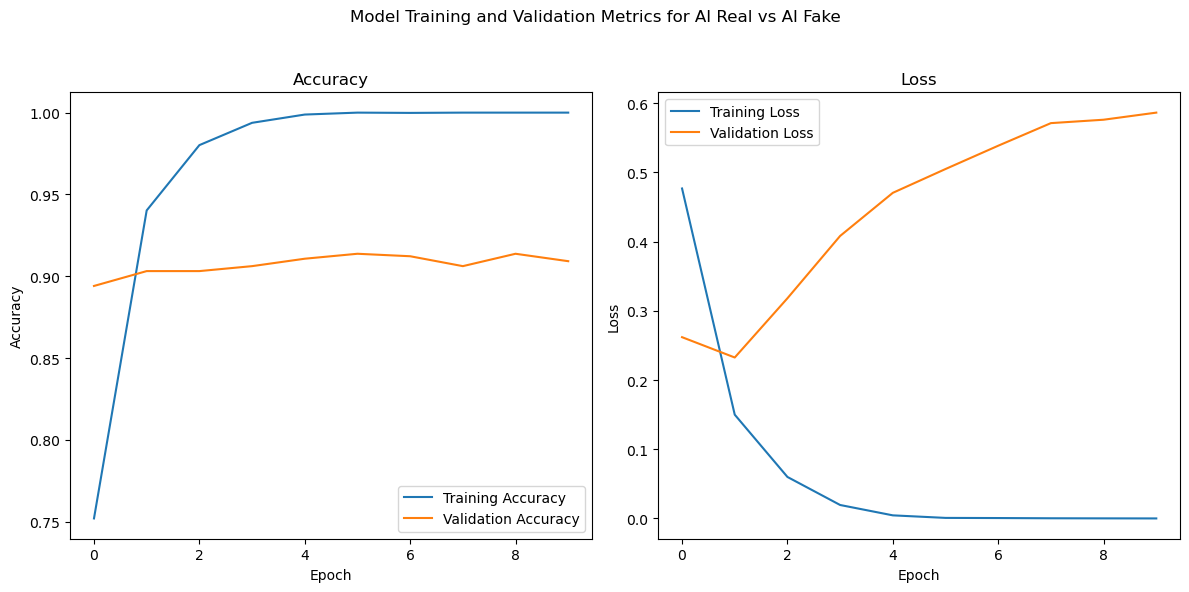

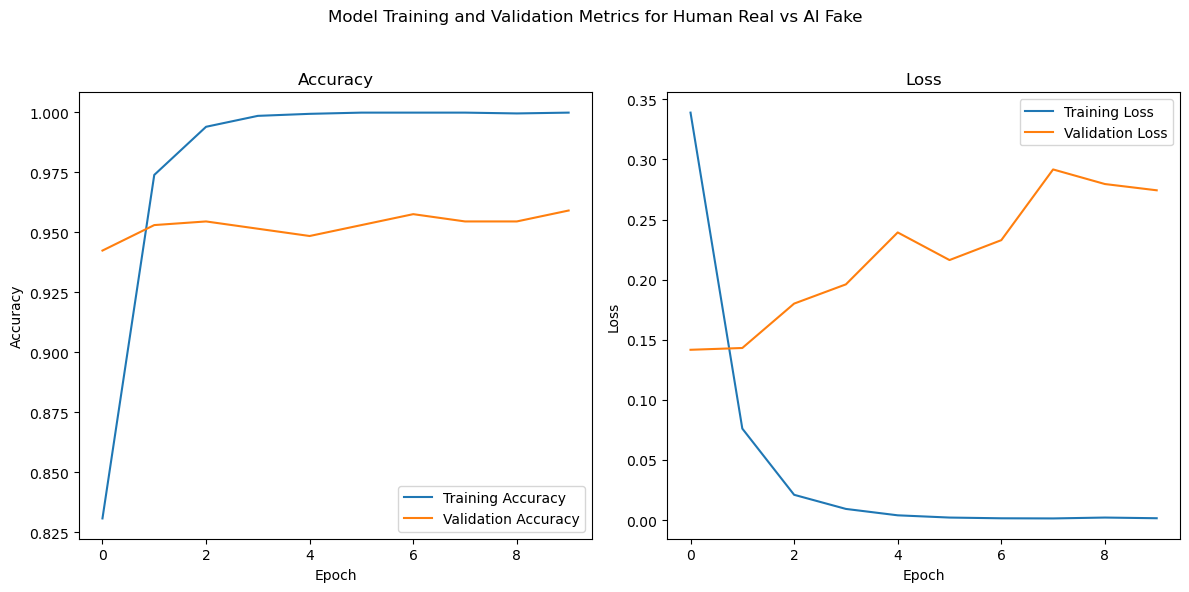

In [99]:
for comparison_name, history in histories.items():
    plot_history(history, comparison_name)

### Training and Validation Process with K-Fold Cross-Validation
  1. **K-Fold Cross-Validation Setup**: Divide the dataset into 'k' consecutive folds (we use 3 in this case). Each fold is then used once as a validation while the k - 1 remaining folds form the training set.
  2. **Model Training**: For each fold, train the CNN model on the training set and validate it on the validation set. This helps in assessing the effectiveness of the model across different subsets of the data.
  3. **History Tracking**: Save the training and validation history for each fold to analyze trends and performance over epochs.
  4. **Performance Evaluation**: Calculate the accuracy for each fold and derive the average accuracy across all folds to gauge the overall performance of the model.
- **Rationale**:
  - Using K-Fold cross-validation helps mitigate the risk of overfitting and provides a more generalizable performance metric compared to a single train-test split.
  - Tracking history across folds allows us to observe the consistency of model learning and identify any variability in performance that could suggest model instability or inadequacy in learning across different data segments.
- **Outputs**:
  - A dictionary of comparison results that stores the accuracy for each text comparison.
  - A dictionary of histories that captures the training and validation dynamics for further graphical analysis.
- **Limitations**:
  - Although K-Fold increases the reliability of model evaluation, it also significantly increases computational cost and time, especially with a larger number of folds or more extensive datasets.


Epoch 1/5


/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5632 - loss: 1.5891 - val_accuracy: 0.0000e+00 - val_loss: 0.7661
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5625 - loss: 0.7003 - val_accuracy: 0.0000e+00 - val_loss: 0.7750
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5704 - loss: 0.6861 - val_accuracy: 0.0000e+00 - val_loss: 0.7831
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5482 - loss: 0.6887 - val_accuracy: 0.0000e+00 - val_loss: 0.8172
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5544 - loss: 0.6876 - val_accuracy: 0.0000e+00 - val_loss: 0.8061
Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5598 - loss: 1.5331 - val_accuracy: 0.0000e+00 - val_loss: 0.7848
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5718 - loss: 0.6948 - val_accuracy: 0.0000e+00 - val_loss: 0.7786
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5608 - loss: 0.6864 

/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5447 - loss: 1.6059 - val_accuracy: 0.0000e+00 - val_loss: 0.7877
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5587 - loss: 0.6991 - val_accuracy: 0.0000e+00 - val_loss: 0.7833
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5504 - loss: 0.6895 - val_accuracy: 0.0000e+00 - val_loss: 0.7808
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5594 - loss: 0.6874 - val_accuracy: 0.0000e+00 - val_loss: 0.7861
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5530 - loss: 0.6881 - val_accuracy: 0.0000e+00 - val_loss: 0.7959
Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5435 - loss: 1.5596 - val_accuracy: 0.0000e+00 - val_loss: 0.7706
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5601 - loss: 0.6971 - val_accuracy: 0.0000e+00 - val_loss: 0.7823
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5684 - loss: 0.6855 

/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.5266 - loss: 1.5453 - val_accuracy: 0.0000e+00 - val_loss: 0.7540
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5480 - loss: 0.6981 - val_accuracy: 0.0000e+00 - val_loss: 0.7640
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5484 - loss: 0.6895 - val_accuracy: 0.0000e+00 - val_loss: 0.7745
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5420 - loss: 0.6896 - val_accuracy: 0.0000e+00 - val_loss: 0.7900
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5340 - loss: 0.6917 - val_accuracy: 0.0000e+00 - val_loss: 0.7889
Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5476 - loss: 1.5455 - val_accuracy: 0.0000e+00 - val_loss: 0.7801
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5517 - loss: 0.6986 - val_accuracy: 0.0000e+00 - val_loss: 0.7777
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5485 - loss: 0.6896 

/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - accuracy: 0.5351 - loss: 1.5702 - val_accuracy: 0.4624 - val_loss: 0.8491
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.8198 - loss: 0.5789 - val_accuracy: 0.8440 - val_loss: 0.7548
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9123 - loss: 0.4818 - val_accuracy: 0.8789 - val_loss: 0.7036
Epoch 4/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9400 - loss: 0.4194 - val_accuracy: 0.8404 - val_loss: 0.7271
Epoch 5/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.9489 - loss: 0.3812 - val_accuracy: 0.8440 - val_loss: 0.7038
Epoch 1/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5532 - loss: 1.5541 - val_accuracy: 0.0000e+00 - val_loss: 0.8381
Epoch 2/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.7119 - loss: 0.6049 - val_accuracy: 0.6587 - val_loss: 0.8266
Epoch 3/5
154/154 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8811 - loss: 0.5111 - val_accuracy: 0.6826 -

/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5615 - loss: 1.5331 - val_accuracy: 0.0000e+00 - val_loss: 0.7845
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5679 - loss: 0.6940 - val_accuracy: 0.0000e+00 - val_loss: 0.7841
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.5657 - loss: 0.6862 - val_accuracy: 0.0000e+00 - val_loss: 0.7890
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5655 - loss: 0.6857 - val_accuracy: 0.0000e+00 - val_loss: 0.8051
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5520 - loss: 0.6888 - val_accuracy: 0.0000e+00 - val_loss: 0.8016
Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5464 - loss: 1.5643 - val_accuracy: 0.0000e+00 - val_loss: 0.7701
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.5736 - loss: 0.6945 - val_accuracy: 0.0000e+00 - val_loss: 0.7863
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.5800 - loss: 0.6835 

/Users/kchoi22/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.5670 - loss: 1.5552 - val_accuracy: 0.5582 - val_loss: 0.8363
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8397 - loss: 0.5536 - val_accuracy: 0.9073 - val_loss: 0.4617
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.9383 - loss: 0.3985 - val_accuracy: 0.8964 - val_loss: 0.4320
Epoch 4/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9551 - loss: 0.3345 - val_accuracy: 0.9618 - val_loss: 0.2976
Epoch 5/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9702 - loss: 0.2920 - val_accuracy: 0.8909 - val_loss: 0.4328
Epoch 1/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5714 - loss: 1.5649 - val_accuracy: 0.6055 - val_loss: 0.8825
Epoch 2/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8800 - loss: 0.5290 - val_accuracy: 0.7873 - val_loss: 0.7869
Epoch 3/5
155/155 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9570 - loss: 0.4259 - val_accuracy: 0.7927 - val

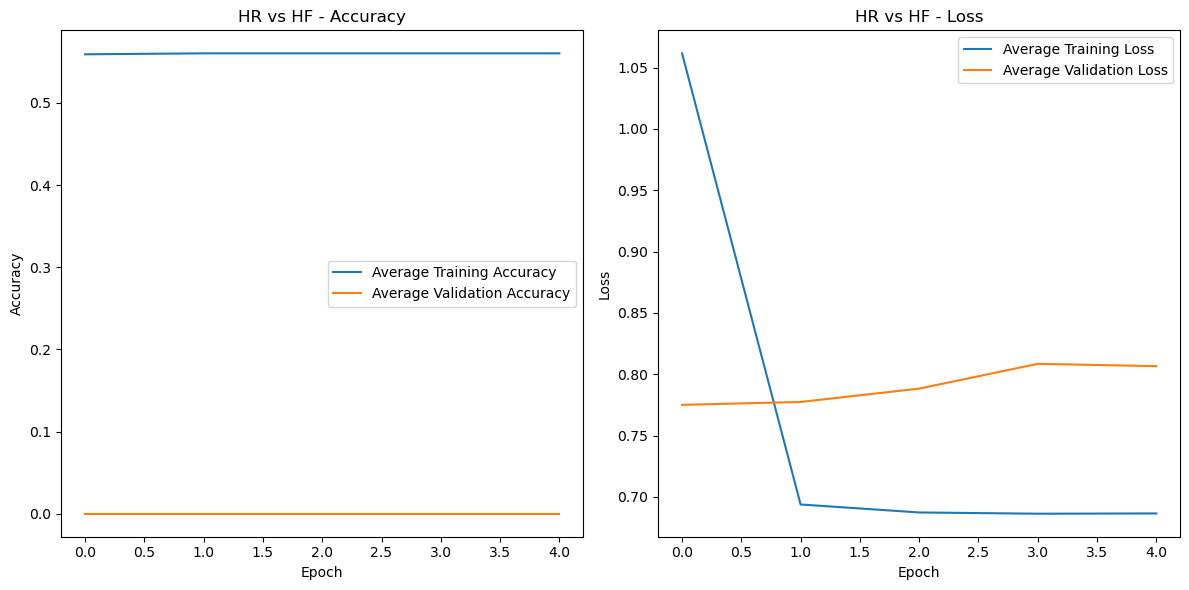

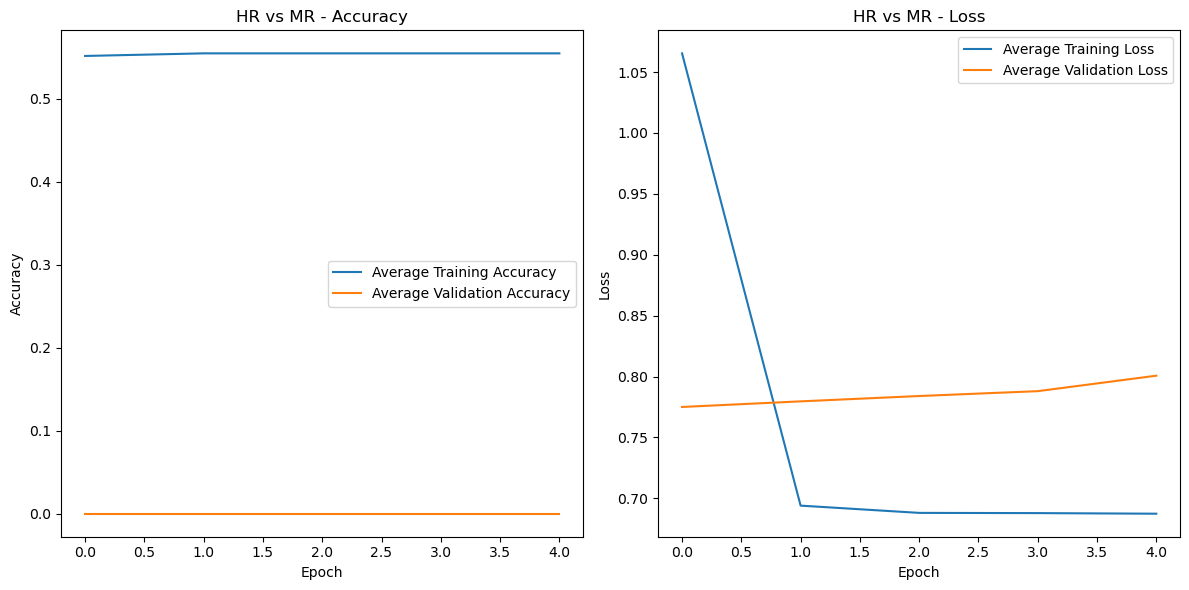

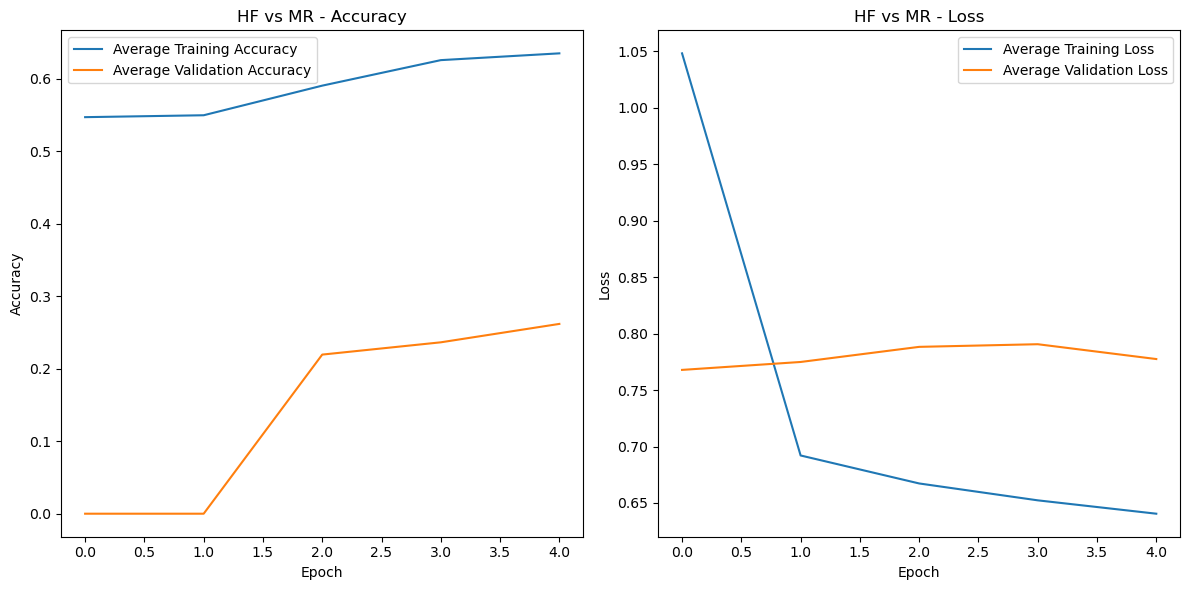

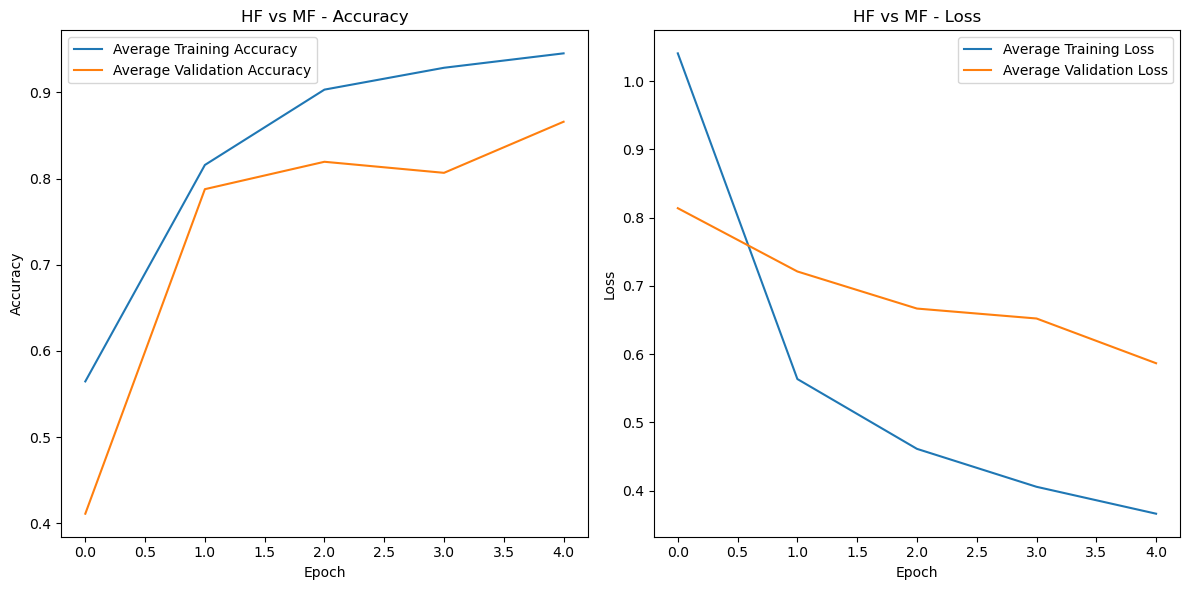

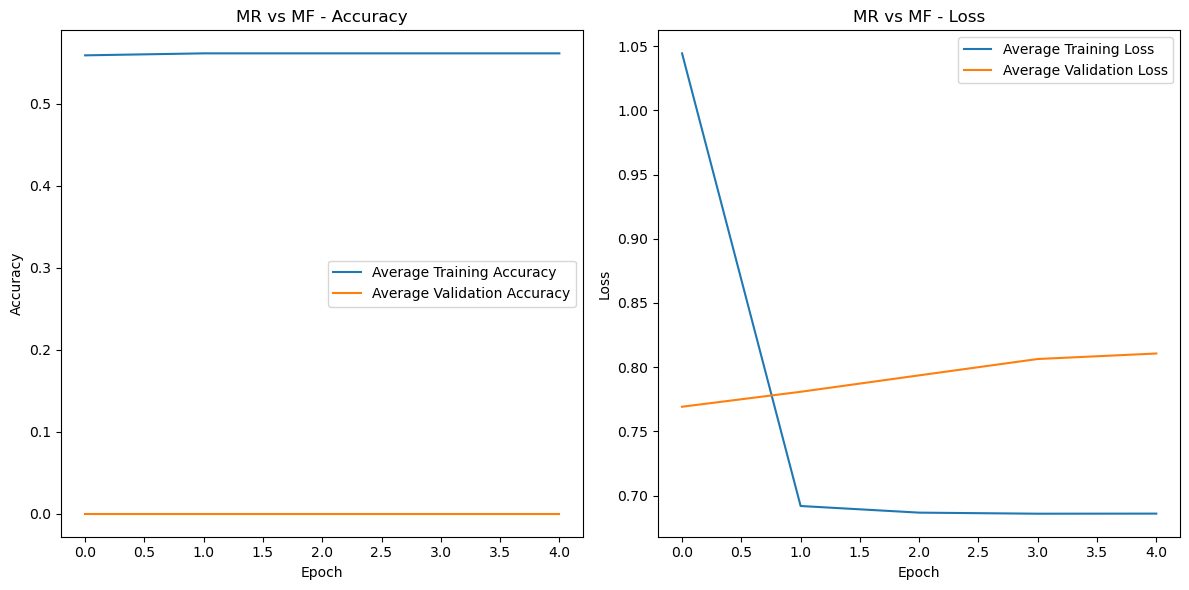

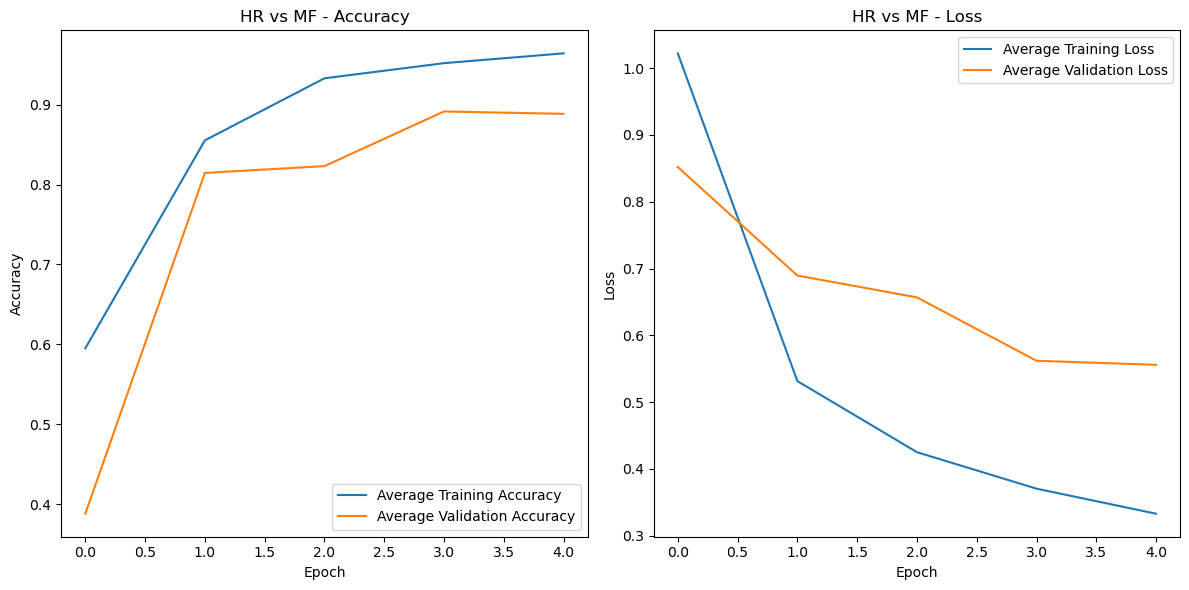

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.regularizers import l2

# Function to create the CNN model
def create_cnn_model():
    model = Sequential([
        Embedding(5000, 50, input_length=100),
        Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling1D(5),
        Dropout(0.5),
        Conv1D(128, 5, activation='relu', kernel_regularizer=l2(0.01)),
        GlobalMaxPooling1D(),
        Dense(10, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Function to train and evaluate using K-Fold cross-validation
def train_and_evaluate(X, y):
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    histories = []
    scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = create_cnn_model()
        history = model.fit(X_train, y_train, epochs=5, validation_split=0.1)
        histories.append(history)
        score = model.evaluate(X_test, y_test, verbose=0)
        scores.append(score[1])

    average_accuracy = np.mean(scores)
    return average_accuracy, histories

# Prepare data and train model
comparison_results = {}
histories_dict = {}
pairs = [('HR', 'HF'), ('HR', 'MR'), ('HF', 'MR'), ('HF', 'MF'), ('MR', 'MF'), ('HR', 'MF')]

for pair in pairs:
    X, y = prepare_data_for_comparison(globals()[f"{pair[0]}_df"], globals()[f"{pair[1]}_df"])
    key = f'{pair[0]} vs {pair[1]}'
    accuracy, histories = train_and_evaluate(X, y)
    comparison_results[key] = accuracy
    histories_dict[key] = histories


# Plotting function to visualize averaged accuracy and loss for each comparison
def plot_average_history(histories, title):
    avg_train_acc = np.mean([h.history['accuracy'] for h in histories], axis=0)
    avg_val_acc = np.mean([h.history['val_accuracy'] for h in histories], axis=0)
    avg_train_loss = np.mean([h.history['loss'] for h in histories], axis=0)
    avg_val_loss = np.mean([h.history['val_loss'] for h in histories], axis=0)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(avg_train_acc, label='Average Training Accuracy')
    plt.plot(avg_val_acc, label='Average Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(avg_train_loss, label='Average Training Loss')
    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.title(f'{title} - Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Assuming `histories_dict` is a dictionary with keys as comparison titles
# and values as lists of history objects from training across different folds.
for title, histories in histories_dict.items():
    plot_average_history(histories, title)
